In [2]:
import numpy as np
from pathlib import Path
import os, json
import matplotlib.pyplot as plt
cwd = Path.cwd()
import UPPtoolbox as upp
import seaborn as sns


# Important variables
SNRs = np.array([-np.inf,-13,-11,-9,-7,-5,-3])
SubIDs = ['01','02','03','05','06','07','08','09','11','12','13','14','15','17','19','20','22','23','24','25']
colormap = {0: (0, 0, 0), 1: (0, 0.25, 1), 2: (0, 0.9375, 1), 3: (0, 0.91, 0.1), 4: (1, 0.6, 0), 5: (1, 0, 0), 6: (0.8, 0, 0)}

In [3]:
# Import real data
import warnings
data_ref = f'myEpochs_Active/Epoch_{SubIDs[18]}-epo.fif'
epochs_file = cwd.parents[0] / data_ref
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    time_series_true = upp.STG(epochs_file, tmin=300, tmax=500)
measures_true = time_series_true.copy()

In [4]:
# set parameters
n_categories = 6

def w_fun(cat):
    return (np.exp(cat/2)-1)/(7.5*np.exp(5/2))

def g_fun(cat):
    return -cat*(cat-6)/65

tau = 10
process_noise, measure_noise = 0.3, 0
threshold = 1
sharpness = 5
ws = {f"w{i}": w_fun(i) for i in range(n_categories)}
gs = {f"g{i}": g_fun(i) for i in range(n_categories)}

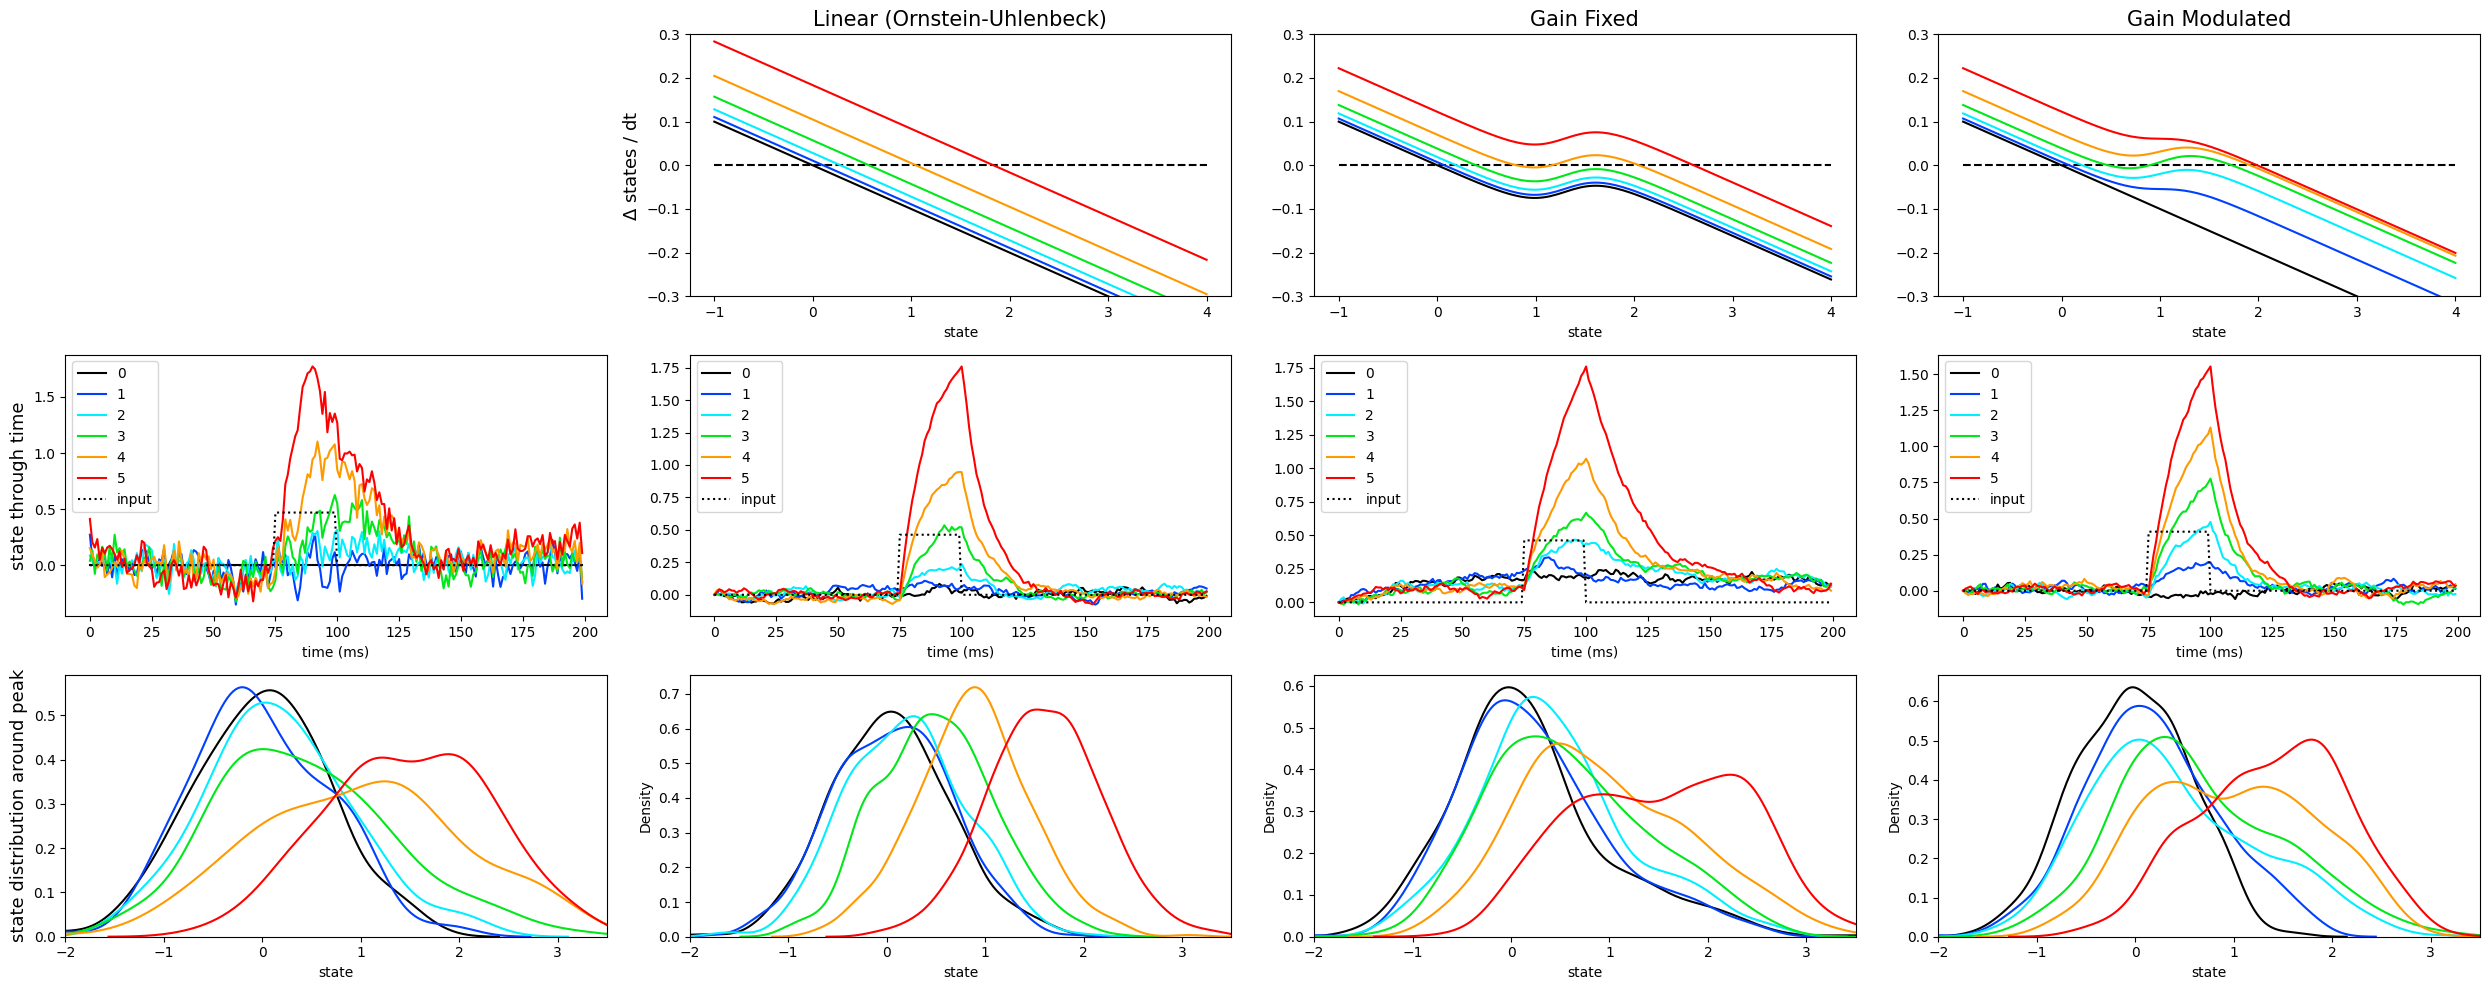

In [14]:
# Define the 3 models for simulations
linear = upp.model.StratifiedLinear(tau=tau, process_noise=process_noise, measure_noise=measure_noise, **{f"w{cat}": ws[f"w{cat}"]*1.5 for cat in range(n_categories)})
nonlinear = upp.model.StratifiedNonLinear1(tau=tau, process_noise=process_noise, measure_noise=measure_noise, threshold=threshold+0.3, sharpness=sharpness, **ws, gain=gs['g3'])
gainmodul = upp.model.StratifiedGainModulation(tau=tau, process_noise=process_noise, measure_noise=measure_noise, threshold=threshold, sharpness=sharpness, **ws, **gs)


n_trials = 500
one_input = np.concatenate((np.zeros(75), np.ones(25), np.zeros(100)))
input_series = np.stack([one_input for _ in range(n_trials)])

categories = list(range(n_categories))

measures_linear = {cat: linear.measure_simulations(initial_state = np.zeros(n_trials), input_series = input_series, signal_category = cat) for cat in categories}

measures_nonlinear = {cat: nonlinear.measure_simulations(initial_state = np.zeros(n_trials), input_series = input_series, signal_category = cat) for cat in categories}

measures_gainmodul = {cat: gainmodul.measure_simulations(initial_state = np.zeros(n_trials), input_series = input_series, signal_category = cat) for cat in categories}


states = np.linspace(-1,4,150)
conditions = [(0, 0), (1, 1), (1,2), (1,3), (1,4), (1,5)]
labels = {cat: str(cat) for cat in range(n_categories)}



plt.figure(figsize=(25, 10))

# Define models and their corresponding measures
models = [
    ("Linear (Ornstein-Uhlenbeck)", linear.core, measures_linear),
    ("Gain Fixed", nonlinear.core, measures_nonlinear),
    ("Gain Modulated", gainmodul.core, measures_gainmodul)
]


# === TOP ROW: Δstate/dt plots ===
for i, (title, model_func, _) in enumerate(models, start=1):
    plt.subplot2grid((9, 4), (0, i), rowspan=3)
    plt.plot([states[0], states[-1]], [0, 0], linestyle='--', color='black')

    for cond_ind, (input_value, signal_category) in enumerate(conditions):
        plt.plot(
            states,
            model_func(states, input_value * np.ones_like(states), signal_category) - states,
            color=colormap[cond_ind],
            label=labels[cond_ind]
        )

    plt.xlabel('state')
    if i == 1:
        plt.ylabel(r'$\Delta$ states / dt', fontsize=13)
    plt.ylim(-0.3,0.3)
    plt.title(title, fontsize=15)

# === MIDDLE ROW: Time-series plots ===
# Define all time-series datasets
time_series_data = [
    ("Real Participant", measures_true),
    ("Linear", measures_linear),
    ("Non-Linear", measures_nonlinear),
    ("Gain Modulation", measures_gainmodul)
]

for i, (title, data_dict) in enumerate(time_series_data):
    plt.subplot2grid((9, 4), (3, i), rowspan=3)

    for cat in categories:
        mean_trace = (
            data_dict[cat][:, :200].mean(0)
            if title == "Real Participant"
            else data_dict[cat].mean(0)
        )
        plt.plot(mean_trace, color=colormap[cat], label=str(cat))

    ymin, ymax = plt.ylim()
    plt.plot(ymax * one_input / 4, color='black', linestyle=':', label='input')

    plt.xlabel('time (ms)')
    if i == 0:
        plt.ylabel('state through time', fontsize=13)
    # plt.title(title, fontsize=15)
    plt.legend(loc='upper left')

# === BOTTOM ROW: KDE distributions ===
t1, t2 = 90, 100
xmin, xmax = -2, 3.5
distribution_data = [
    ("Real Participant", measures_true),
    ("Linear", measures_linear),
    ("Non-Linear", measures_nonlinear),
    ("Gain Modulation", measures_gainmodul)
]

for i, (title, data_dict) in enumerate(distribution_data):
    plt.subplot2grid((9, 4), (6, i), rowspan=3)

    avgs = {cat: np.mean(data_dict[cat][:, t1:t2], -1).flatten() for cat in categories}
    for cat in categories:
        sns.kdeplot(data=avgs[cat], label=str(cat), color=colormap[cat])

    plt.xlim(xmin, xmax)
    plt.xlabel('state')
    if i == 0:
        plt.ylabel('state distribution around peak', fontsize=13)
    # plt.title(title, fontsize=15)

plt.tight_layout()
plt.savefig('PapersFigure2.png')
plt.show()


In [144]:
def plot_model_densities(linear_data, nonlinear_data, gainmod_data, category=0, bins_y=10, level=0.5, figsize=(15, 5), save_path=None):
    
    models = {
        "Linear": linear_data[category][:, 10:],
        "NonLinear": nonlinear_data[category][:, 10:],
        "GainModulated": gainmod_data[category][:, 10:]
    }

    # Determine shared value range across all datasets
    all_vals = np.concatenate([v.flatten() for v in models.values()])
    y_min, y_max = np.percentile(all_vals, [1, 99])

    fig, axes = plt.subplots(1, len(models), figsize=figsize, sharex=True, sharey=True)

    for ax, (name, data) in zip(axes, models.items()):
        n_trials, n_time = data.shape
        y_edges = np.linspace(y_min, y_max, bins_y + 1)
        density = np.zeros((bins_y, n_time))

        # Compute density histogram for each time step
        for t in range(n_time):
            hist, _ = np.histogram(data[:, t], bins=y_edges, density=True)
            density[:, t] = hist

        # Plot heatmap
        sns.heatmap(
            density,
            ax=ax,
            cmap="viridis",
            cbar=True,
            xticklabels=50,
            yticklabels=False,
            vmax=2
        )

        # Add red contour line where density >= threshold
        x = np.arange(n_time)
        y = np.arange(bins_y)
        X, Y = np.meshgrid(x, y)
        ax.contour(X, Y, density, levels=[level], colors='red', linewidths=1.5)

        ax.set_title(name)
        ax.set_xlabel("Time")
        if ax == axes[0]:
            ax.set_ylabel("State value density (low → high)")
        ax.invert_yaxis()  # so high values appear on top

    plt.tight_layout()
    plt.show()

cat 3:


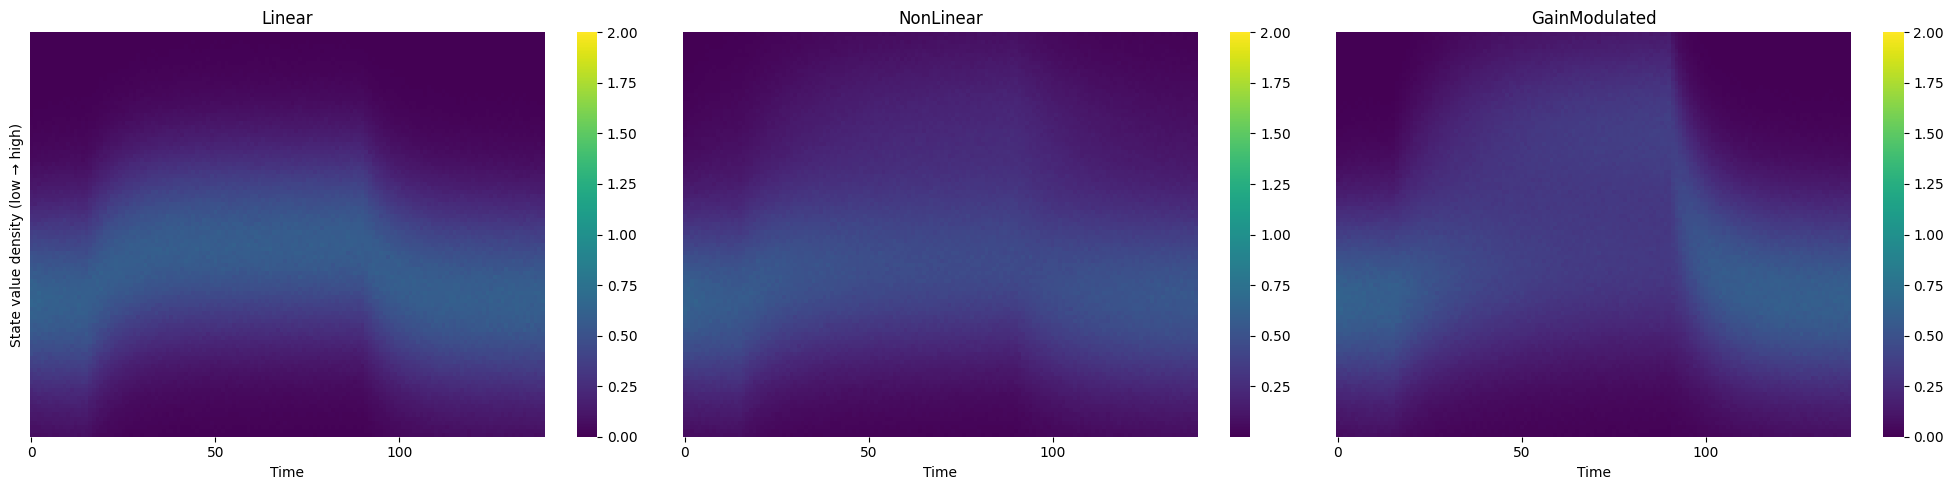

cat 4:


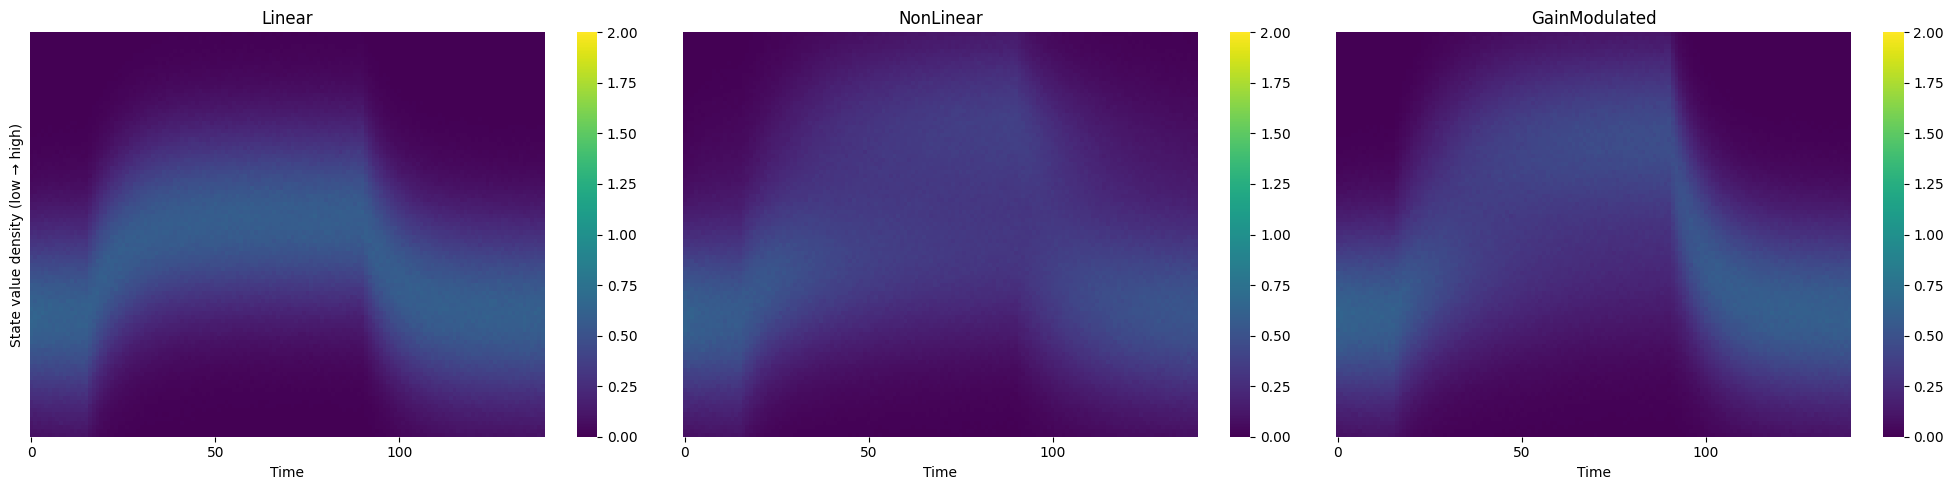

In [107]:
n_trials = 100000
one_input = np.concatenate((np.zeros(25), np.ones(75), np.zeros(50)))
input_series = np.stack([one_input for _ in range(n_trials)])

measures_linear = {cat: linear.measure_simulations(initial_state = np.zeros(n_trials), input_series = input_series, signal_category = cat) for cat in categories}
measures_nonlinear = {cat: nonlinear.measure_simulations(initial_state = np.zeros(n_trials), input_series = input_series, signal_category = cat) for cat in categories}
measures_gainmodul = {cat: gainmodul.measure_simulations(initial_state = np.zeros(n_trials), input_series = input_series, signal_category = cat) for cat in categories}

print('cat 3:')
plot_model_densities(linear_data=measures_linear, nonlinear_data=measures_nonlinear, gainmod_data=measures_gainmodul, category=3, bins_y=100, figsize=(20, 5))
print('cat 4:')
plot_model_densities(linear_data=measures_linear, nonlinear_data=measures_nonlinear, gainmod_data=measures_gainmodul, category=4, bins_y=100, figsize=(20, 5))

cat 4:


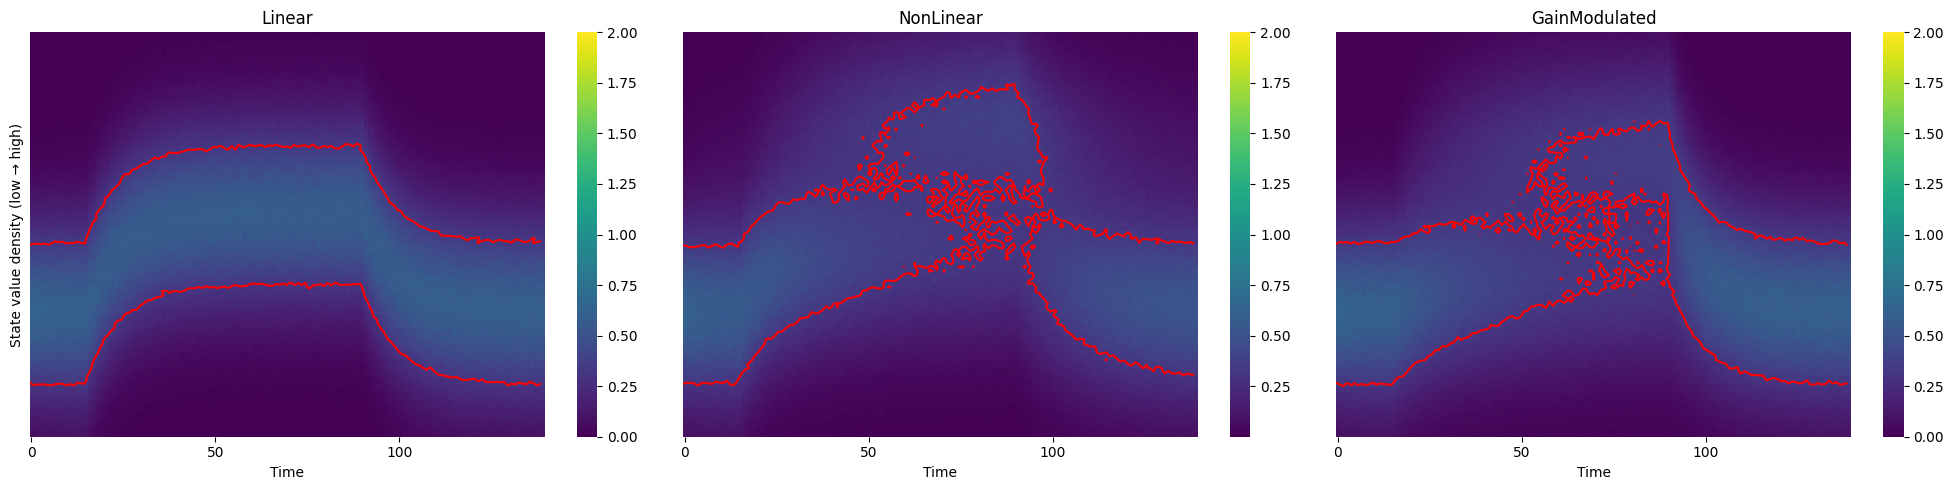

In [146]:
modified_gainmodul = measures_gainmodul.copy()
modified_gainmodul[4] = modified_gainmodul[3]

# print('cat 3:')
# plot_model_densities(linear_data=measures_linear, nonlinear_data=measures_nonlinear, gainmod_data=measures_gainmodul, category=3, bins_y=100, level=0.325, figsize=(20, 5))
print('cat 4:')
plot_model_densities(linear_data=measures_linear, nonlinear_data=measures_nonlinear, gainmod_data=modified_gainmodul, category=4, bins_y=100, level=0.325, figsize=(20, 5), save_path='PapersFigure1.png')

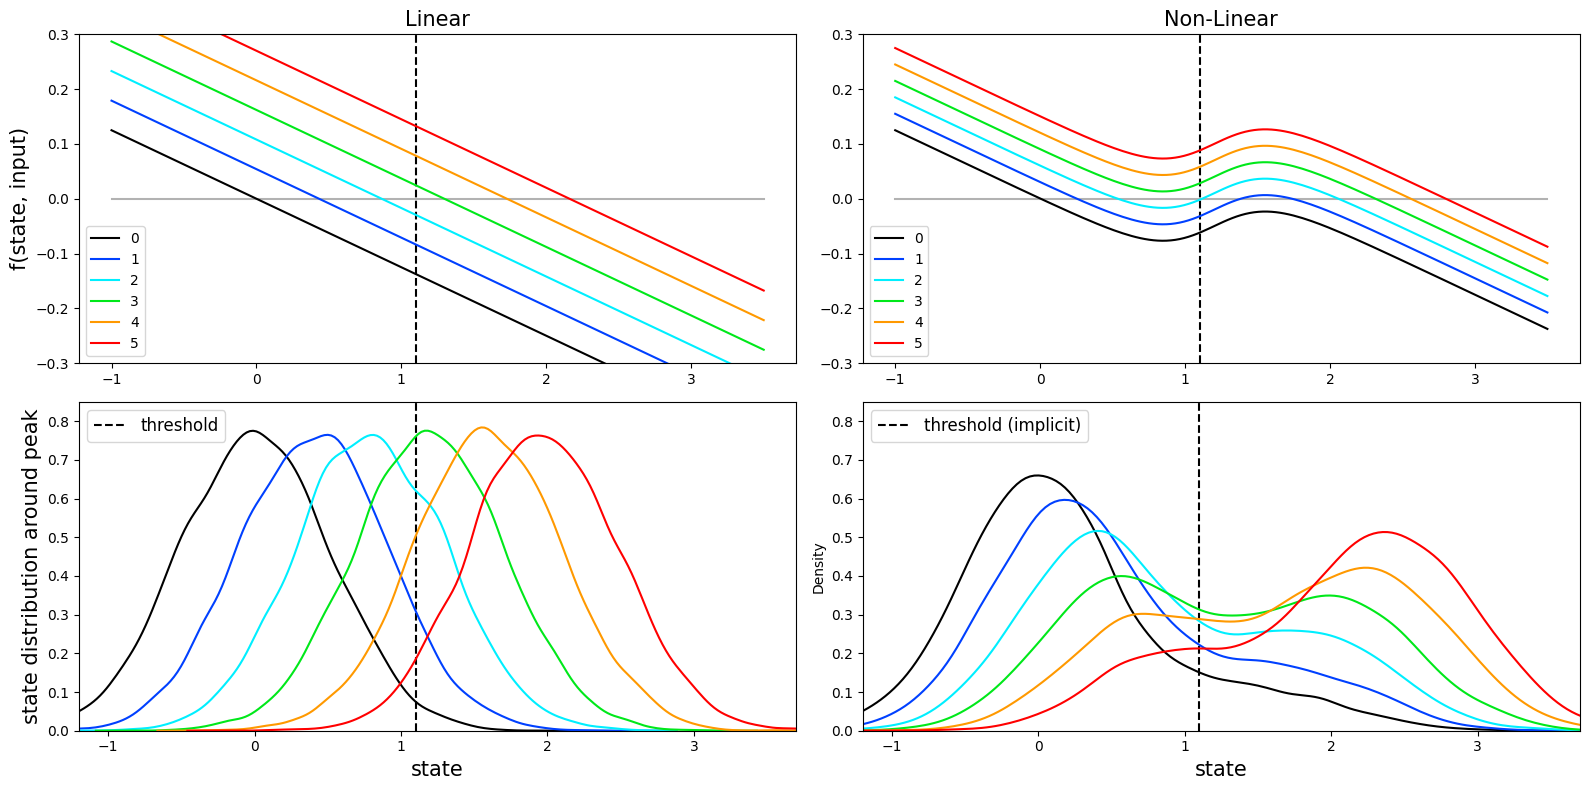

In [54]:
tau = 8
process_noise, measure_noise = 0.3, 0
threshold = 1.2
sharpness = 5
ws = {'w0': 0, 'w1': 0.03, 'w2': 0.06, 'w3': 0.09, 'w4': 0.12, 'w5': 0.15}


# Define the 3 models for simulations
linear = upp.model.StratifiedLinear(tau=tau, process_noise=process_noise, measure_noise=measure_noise, **{f"w{cat}": ws[f"w{cat}"]*1.8 for cat in range(n_categories)})
nonlinear = upp.model.StratifiedNonLinear1(tau=tau, process_noise=process_noise, measure_noise=measure_noise, threshold=threshold, sharpness=sharpness, **ws, gain=0.2)


n_trials = 10000
one_input = np.concatenate((np.zeros(75), np.ones(25), np.zeros(100)))
input_series = np.stack([one_input for _ in range(n_trials)])

categories = list(range(n_categories))

measures_linear = {cat: linear.measure_simulations(initial_state = np.zeros(n_trials), input_series = input_series, signal_category = cat) for cat in categories}

measures_nonlinear = {cat: nonlinear.measure_simulations(initial_state = np.zeros(n_trials), input_series = input_series, signal_category = cat) for cat in categories}


# ============================================
# PLOTTING: Only Linear + Fixed Gain, no middle row
# ============================================

states = np.linspace(-1, 3.5, 150)
conditions = [(0, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
labels = {cat: str(cat) for cat in range(n_categories)}

# Keep only the two models you want
models = [
    ("Linear", linear.core, measures_linear),
    ("Non-Linear", nonlinear.core, measures_nonlinear)
]

distribution_data = [
    ("Linear", measures_linear),
    ("Non-Linear", measures_nonlinear)
]

t1, t2 = 90, 100
xmin, xmax = -1.2, 3.7

plt.figure(figsize=(16, 8))

# === TOP ROW: Δstate/dt plots ===
for i, (title, model_func, _) in enumerate(models):
    plt.subplot2grid((2, 2), (0, i))
    plt.plot([states[0], states[-1]], [0, 0], color='black', alpha=0.3)
    plt.plot([1.1, 1.1], [-0.3, 0.3], color='black', linestyle='--')

    for cond_ind, (input_value, signal_category) in enumerate(conditions):
        plt.plot(
            states,
            model_func(states, input_value * np.ones_like(states), signal_category) - states,
            color=colormap[cond_ind],
            label=labels[cond_ind]
        )

    # plt.xlabel('state')
    if i == 0:
        plt.ylabel('f(state, input)', fontsize=15)
    plt.ylim(-0.3, 0.3)
    plt.title(title, fontsize=15)
    plt.legend(loc='lower left')

# === BOTTOM ROW: KDE distributions ===
for i, (title, data_dict) in enumerate(distribution_data):
    plt.subplot2grid((2, 2), (1, i))
    plt.plot([1.1, 1.1], [0, 0.9], color='black', linestyle='--', label='threshold' if i==0 else 'threshold (implicit)')

    avgs = {cat: np.mean(data_dict[cat][:, t1:t2], -1).flatten() for cat in categories}
    for cat in categories:
        sns.kdeplot(data=avgs[cat], color=colormap[cat])

    plt.xlim(xmin, xmax)
    plt.ylim(0, 0.85)
    plt.xlabel('state', fontsize=15)
    if i == 0:
        plt.ylabel('state distribution around peak', fontsize=15)
    plt.legend(loc='upper left', fontsize=12)

plt.tight_layout()
plt.savefig('PapersFigure3.png')
plt.show()
